In [1]:
from transformers import BertTokenizer, BertModel,get_linear_schedule_with_warmup, AdamW
from transformers import AutoTokenizer, AutoModelForMaskedLM
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import numpy as np
import time, re
from sklearn.model_selection import train_test_split
import os, unicodedata
from pytorch_lightning import Trainer,LightningDataModule,LightningModule
from torch.nn import functional as F
from pytorch_lightning.metrics import functional, Accuracy
from pytorch_lightning.callbacks import ProgressBar, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


from sklearn.metrics import accuracy_score,classification_report
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
source_dir='../data/model/'

In [4]:
version=time.strftime('%Y%m%d-%H%M%S')
version='20210316-192256'

In [5]:
def get_model_path(source_dir,model_name,version):
    def remove_empty_dir(md):
        if not os.path.exists(md):
            return True
        if not os.listdir(md):
            os.rmdir(md)
        if os.path.exists(md):
            return False
        return True
    md=os.path.join(source_dir,version)
    os.makedirs(md, exist_ok=True)
    if os.path.exists(md):
        remove_empty_dir(md)
        return md, os.path.join(md,model_name)
    else:
        return None,None

In [6]:
bert_path='../../resource/bert_base_chinese/'

In [7]:
%%time
tokenizer=BertTokenizer.from_pretrained(bert_path)
bert=BertModel.from_pretrained(bert_path)

CPU times: user 11.2 s, sys: 1.11 s, total: 12.3 s
Wall time: 2.32 s


In [8]:
class MyClassifier(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.bert=bert
        self.dense1=nn.Linear(768*2,128)
        self.dense2=nn.Linear(128,1)
        self.train_acc=Accuracy()
        self.valid_acc=Accuracy()
        self.test_acc=Accuracy()
        self.predicts=[]
        self.labels=[]
        self.tmp=[0,0]
    
    def setup(self, stage):
        self.predicts, self.labels=[],[]
    
    def forward(self,x):
        x1,x2=x
        pooled_out=self.bert(
            input_ids=x1['input_ids'],
            attention_mask=x1['attention_mask'],
            token_type_ids=x1['token_type_ids']
        )['pooler_output']
        v1=pooled_out.mean(-2)
        v2=self.bert(
            input_ids=x2['input_ids'],
            attention_mask=x2['attention_mask'],
            token_type_ids=x2['token_type_ids']
        )['pooler_output']
        v=torch.cat((v1,v2.reshape(-1)))
        v=nn.Tanh()(self.dense1(v))
        v=nn.Sigmoid()(self.dense2(v))
        return v
    
    def _step(self, batch, batch_idx):
        loss,n=0.0,len(batch)
        yhs,ys=[],[]
        for x,y in batch:
            yh=self(x)
            loss+=F.binary_cross_entropy(yh,y)
            yhs.append(yh)
            ys.append(y)
        loss/=n
        return loss,torch.tensor(yhs),torch.tensor(ys)
    
    def training_step(self, batch, batch_idx):
        loss, yhs, ys = self._step(batch, batch_idx)
        self.train_acc(yhs,ys)
        self.log('train_acc', self.train_acc, on_epoch=True ,prog_bar=True)
        return loss
    
    def training_epoch_end(self,losses):
        acc=self.train_acc.compute()
        self.tmp[0]=acc
        
    def validation_step(self, batch, batch_idx):
        _, yhs, ys = self._step(batch, batch_idx)
        self.valid_acc(yhs,ys)
    
    def validation_epoch_end(self,losses):
        acc=self.valid_acc.compute()
        self.log('valid_acc', self.valid_acc, prog_bar=True, logger=True)
        self.tmp[1]=acc
        print(f'train_acc={self.tmp[0]:.4f}, valid_acc={self.tmp[1]:.4f}')
        
    def test_step(self, batch, batch_idx):
        _, yhs, ys = self._step(batch, batch_idx)
        self.predicts+=yhs.tolist()
        self.labels+=ys.tolist()
        acc=self.test_acc(yhs, ys)
        
    def test_epoch_end(self, losses):
        print(f'test_acc={self.test_acc.compute():.4f}')
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)
    
    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items
        
model=MyClassifier()

In [9]:
max_length=512

In [10]:
def test_inference(model):
    s1 = ['我要圣诞礼物毕业礼物',
          '还有新年礼物',
          '对的',
          '你嫁我好了',
          '就那么点礼物就要我跟你走？',
          '那我跟你走',
          '我买不起礼物']
    s2 = '你就是我最好的礼物'
    X1=tokenizer(s1,padding=True,truncation=True,return_tensors='pt',max_length=max_length)
    X2=tokenizer(s2,padding=True,truncation=True,return_tensors='pt',max_length=max_length)
    return model([X1,X2])

test_inference(model)

tensor([0.4047], grad_fn=<SigmoidBackward>)

In [11]:
class MyDataset(Dataset):
    def __init__(self, df):
        self.df=df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,i):
        row=self.df.iloc[i].fillna('')
        q1=row['q1'].split('|')
        q2=row['q2']
        y=row['y'] if 'y' in row else 0
        x1=tokenizer(q1,padding=True,truncation=True,return_tensors='pt',max_length=max_length)
        x2=tokenizer(q2,padding=True,truncation=True,return_tensors='pt',max_length=max_length)
        return (x1,x2),torch.tensor([y],dtype=torch.float)
#         return (q1,q2),y
    
    @classmethod
    def collate_fn(cls, batch):
        return batch

In [12]:
data_paths=['../data/data_random_only/train.csv', 
            '../data/data_random_only/valid.csv', 
            '../data/data_test/test.csv']

In [13]:
nrow_train, nrow_other=1000000, None

In [14]:
data_valid=pd.read_csv(data_paths[1], nrows=nrow_other)
data_test=pd.read_csv(data_paths[2], nrows=nrow_other)

In [15]:
%%time
data_train=pd.read_csv(data_paths[0], nrows=nrow_train)

CPU times: user 2.22 s, sys: 164 ms, total: 2.38 s
Wall time: 2.38 s


In [16]:
data_train.shape, data_valid.shape, data_test.shape

((1000000, 3), (73834, 3), (33342, 3))

In [17]:
data_train.head(20)

,q1,q2,y
0,这位同学注意回消息|偏不,看我对你多好呀一起来就找你,0
1,我是说真的～小时候过河走独木桥～我晕啊晕啊的就掉河里啦|这也行|嗯呢～我记得呢大概四五岁的样...,好呀～我想过失忆呢看电视看的,1
2,还会搭龟梯，真聪明！赏点吃的|那天带点来|你还没睡呢|你不也是,反正你们都不爱我了,0
3,我准备拿你当礼物送给妹子|我谢谢你！求之不得啊,知道10个女人和一个男人在岛上的故事么,1
4,刚好放暑假了给你阿,我怕你的老师会爱上我,1
5,怎么才能坚持书摘,我喜欢冬天不怕冷,0
6,赵小国麻辣烫|这你都知道,今晚不用开空调了,0
7,戴口罩的大明星|小心有雾霾,哪里要我带了吸尘器去吗,1
8,走，上夜班|起开,我要起床，准备上班了,1
9,嗨呀回来请我吃饭吗|嗨呀大忙人我哪里见得到你哟,嗨呀你这样说就好气,1


In [18]:
batch_size=16

In [19]:
dl_train=DataLoader(MyDataset(data_train),pin_memory=True,batch_size=batch_size, collate_fn=MyDataset.collate_fn)
dl_valid=DataLoader(MyDataset(data_valid),pin_memory=True,batch_size=batch_size, collate_fn=MyDataset.collate_fn)
dl_test=DataLoader(MyDataset(data_test),pin_memory=True,batch_size=batch_size, collate_fn=MyDataset.collate_fn)

In [20]:
md,mp=get_model_path(source_dir, 'model', version)
md,mp

('../data/model/20210316-192256', '../data/model/20210316-192256/model')

In [24]:
ckpt=ModelCheckpoint(filepath=mp, monitor='valid_acc', save_top_k=1)
csv_logger=CSVLogger(md,'log')
trainer=Trainer(gpus=[1], max_epochs=2, callbacks=[ckpt], logger=csv_logger)

/home/zj/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/zj/xiebing/jupyter/topic manage/data/model/20210316-192256 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [21]:
trainer.fit(model, dl_train, dl_valid)


  | Name      | Type      | Params
----------------------------------------
0 | bert      | BertModel | 102 M 
1 | dense1    | Linear    | 196 K 
2 | dense2    | Linear    | 129   
3 | train_acc | Accuracy  | 0     
4 | valid_acc | Accuracy  | 0     
5 | test_acc  | Accuracy  | 0     
----------------------------------------
102 M     Trainable params
0         Non-trainable params
102 M     Total params
/home/zj/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 104 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

train_acc=0.0000, valid_acc=0.5312


/home/zj/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 104 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

train_acc=0.0000, valid_acc=0.6859


Validating: 0it [00:00, ?it/s]

train_acc=0.6531, valid_acc=0.7112


1

In [22]:
log_dir=os.path.join(md,'log')
d=os.listdir(log_dir)[-1]
fp=os.path.join(md,'log',d,'metrics.csv')
history=pd.read_csv(fp)

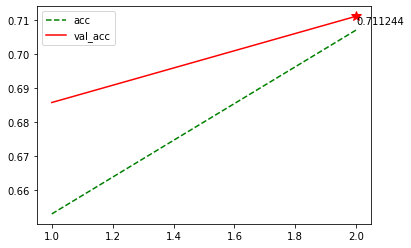

In [23]:
def plot_curve(history):
    tran_acc=history['train_acc_epoch'][history['train_acc_epoch'].notna()]
    valid_acc=history['valid_acc'][history['valid_acc'].notna()]
    fig=plt.figure()
    x=range(1,len(tran_acc)+1)
    plt.plot(x, tran_acc, 'g--')
    plt.plot(x, valid_acc, 'r')
    idx=valid_acc.argmax()
    mv=valid_acc.iloc[idx]
    plt.plot(idx+1,mv,'r*',markersize=10)
    plt.legend(['acc','val_acc'], loc=2)
    plt.annotate(f'{mv:.6}', xy=(idx+1, mv),  xycoords='data',
                xytext=(idx+1,mv),
                horizontalalignment='left', verticalalignment='top')
    return fig
fig=plot_curve(history)

In [22]:
model=model.load_from_checkpoint('../data/model/20210316-192256/model.ckpt')

In [25]:
trainer.test(model,test_dataloaders=dl_test)
result=classification_report(model.labels,pd.Series(model.predicts)>=0.5, digits=6)
print(result)

/home/zj/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 104 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

test_acc=0.7300
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0   0.664874  0.750174  0.704953     14334
         1.0   0.791426  0.714857  0.751196     19008

    accuracy                       0.730040     33342
   macro avg   0.728150  0.732516  0.728074     33342
weighted avg   0.737020  0.730040  0.731315     33342



In [25]:
nb_name=None

In [26]:
%%javascript
IPython.notebook.save_notebook()
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [27]:
if not nb_name:
    nb_name='train.ipynb'
    print('name assigned')

name assigned


In [28]:
os.system(f'jupyter nbconvert --output-dir {md} --to html {nb_name}')

0

In [36]:
data_test['yh']=(pd.Series(model.predicts)>=0.5).map({True:1,False:0})

In [38]:
badcase=data_test[data_test['y']!=data_test['yh']]

In [40]:
md

'../data/model/20210316-192256'

In [41]:
badcase.to_csv(os.path.join(md, 'badcase.csv'))